## Wczytanie danych z pliku

In [1]:
import pandas as pd

data = pd.read_csv("hourly_irish_weather.csv")
print(data)
print(data.shape)

         Unnamed: 0                 date       station   county  longitude  \
0                 0  1989-01-01 00:00:00  Cork_Airport     Cork     -8.485   
1                 1  1989-01-01 01:00:00  Cork_Airport     Cork     -8.485   
2                 2  1989-01-01 02:00:00  Cork_Airport     Cork     -8.485   
3                 3  1989-01-01 03:00:00  Cork_Airport     Cork     -8.485   
4                 4  1989-01-01 04:00:00  Cork_Airport     Cork     -8.485   
...             ...                  ...           ...      ...        ...   
4218049     4497433  2017-12-31 19:00:00    Malin_head  Donegal     -7.339   
4218050     4497434  2017-12-31 20:00:00    Malin_head  Donegal     -7.339   
4218051     4497435  2017-12-31 21:00:00    Malin_head  Donegal     -7.339   
4218052     4497436  2017-12-31 22:00:00    Malin_head  Donegal     -7.339   
4218053     4497437  2017-12-31 23:00:00    Malin_head  Donegal     -7.339   

         latitude  rain  temp  wetb  dewpt  ...  rhum     msl  

## Usunięcie niepełnych danych

In [2]:
data.dropna(inplace=True)
print(data.shape)

(1769250, 21)


## Usunięcie zbędnych kolumn;

Zostają:
* Data i godzina - date
* nazwa stacji - station
* opad deszczu w (mm) - rain
* temperatura (°C) - temp
* Wilgotność względna (%) - rhum
* ciśnienie npm (hpa) - msl
* średnia prędkość wiatru (kt) - wdsp
* kod synoptyczny (0-100) - ww
* czas naslonecznienia (h) - sun
* widoczność (m) - vis

In [3]:
data.drop(columns=["Unnamed: 0","county", "longitude", "latitude","wetb","dewpt","vappr", "wddir", "w", "clht", "clamt"], inplace=True)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

## Wydzielenie daty i okresu godzinowego

In [4]:
data["dateTime"] = pd.to_datetime(data["date"])
data["day"] = data["dateTime"].apply(func=lambda x: x.date())
data["hour"] = data["dateTime"].apply(func=lambda x: x.hour)
data["is_22_5"] = data["hour"].apply(func=lambda x: int(x>=22 or x<=5))
data["is_6_13"] = data["hour"].apply(func=lambda x: int(x>=6 and x<=13))
data["is_14_21"] = data["hour"].apply(func=lambda x: int(x>=14 and x<=21))

## Wydzielenie miesiąca

In [5]:
data["is_jan_feb"] = data["dateTime"].apply(func=lambda x: int(x.month==1 or x.month==2))
data["is_mar_apr"] = data["dateTime"].apply(func=lambda x: int(x.month==3 or x.month==4))
data["is_may_jun"] = data["dateTime"].apply(func=lambda x: int(x.month==5 or x.month==6))
data["is_jul_aug"] = data["dateTime"].apply(func=lambda x: int(x.month==7 or x.month==8))
data["is_sep_oct"] = data["dateTime"].apply(func=lambda x: int(x.month==9 or x.month==10))
data["is_nov_dec"] = data["dateTime"].apply(func=lambda x: int(x.month==11 or x.month==12))

## Wydzielenie typu pogody - na podstawie pogody w

In [6]:
data["is_type_0"] = data["ww"].apply(func=lambda x: int(x<10))
data["is_type_1"] = data["ww"].apply(func=lambda x: int(x>=10 and x<20))
data["is_type_2"] = data["ww"].apply(func=lambda x: int(x>=20 and x<30))
data["is_type_3"] = data["ww"].apply(func=lambda x: int(x>=30 and x<40))
data["is_type_4"] = data["ww"].apply(func=lambda x: int(x>=40 and x<50))
data["is_type_5"] = data["ww"].apply(func=lambda x: int(x>=50 and x<60))
data["is_type_6"] = data["ww"].apply(func=lambda x: int(x>=60 and x<70))
data["is_type_7"] = data["ww"].apply(func=lambda x: int(x>=70 and x<80))
data["is_type_8"] = data["ww"].apply(func=lambda x: int(x>=80 and x<90))
data["is_type_9"] = data["ww"].apply(func=lambda x: int(x>=90))

## Wydzielanie kolumny odpowiedzialnej za przydziałdo serii

In [7]:
data["day_on_station"] = data["day"].astype(str) + data["station"]

## Usunięcie nepotrzebnych kolumn czasu i miejsca

In [8]:
data.drop(columns=["dateTime", "day", "hour", "date", "station", "ww"], inplace=True)

print(data.columns)

Index(['rain', 'temp', 'rhum', 'msl', 'wdsp', 'sun', 'vis', 'is_22_5',
       'is_6_13', 'is_14_21', 'is_jan_feb', 'is_mar_apr', 'is_may_jun',
       'is_jul_aug', 'is_sep_oct', 'is_nov_dec', 'is_type_0', 'is_type_1',
       'is_type_2', 'is_type_3', 'is_type_4', 'is_type_5', 'is_type_6',
       'is_type_7', 'is_type_8', 'is_type_9', 'day_on_station'],
      dtype='object')


## Konwersja na tensor 3 wymiarowy

In [9]:
import numpy as np

print(data.shape)
g = data.groupby('day_on_station').cumcount()
_list = (data
     .set_index(['day_on_station',g])
       .unstack(fill_value=0)
       .stack().groupby(level=0)
       .apply(lambda x: x.values.tolist())
       .tolist())

data = np.array(_list)
print(data.shape)

(1769250, 27)
(74973, 24, 26)


## Normalizacja danych

In [10]:
data = data / np.abs(data).max(axis=0)
data = np.nan_to_num(data)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


## Wydzielenie zbiorów

In [11]:
from sklearn.model_selection import train_test_split

X = np.swapaxes(data[:, :23, :],1,2)
Y = np.swapaxes(data[:, 23:, :],1,2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
print("Dane treningowe: "+ str(X_train.shape))

Dane treningowe: (56229, 26, 23)


## Definicja sieci

### Własna funkcja straty

In [91]:
def loss_func(y_actual, y_predicted):
    return ((y_actual[0,0] - y_predicted[0,0]) ** 2 + \
           (y_actual[0,1] - y_predicted[0,1]) ** 2 + \
           (y_actual[0,2] - y_predicted[0,2]) ** 2 + \
           (y_actual[0,3] - y_predicted[0,3]) ** 2 + \
           (y_actual[0,4] - y_predicted[0,4]) ** 2 + \
           (y_actual[0,5] - y_predicted[0,5]) ** 2 + \
           (y_actual[0,6] - y_predicted[0,6]) ** 2 + \
           (y_actual[0,16] - y_predicted[0,16]) ** 2 + \
           (y_actual[0,17] - y_predicted[0,17]) ** 2 + \
           (y_actual[0,18] - y_predicted[0,18]) ** 2 + \
           (y_actual[0,19] - y_predicted[0,19]) ** 2 + \
           (y_actual[0,20] - y_predicted[0,20]) ** 2 + \
           (y_actual[0,21] - y_predicted[0,21]) ** 2 + \
           (y_actual[0,22] - y_predicted[0,22]) ** 2 + \
           (y_actual[0,23] - y_predicted[0,23]) ** 2 + \
           (y_actual[0,24] - y_predicted[0,24]) ** 2 + \
           (y_actual[0,25] - y_predicted[0,25]) ** 2)/17

In [122]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow_core.python.keras.optimizer_v2.rmsprop import RMSProp

model = Sequential()
model.add(Dense(128, input_shape=(26, 23), activation="relu"))
model.add(LSTM(units=128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(26))
model.compile(loss=loss_func, optimizer=RMSProp(lr=0.01), metrics=['accuracy'])

## Uczenie

In [123]:
model.fit(X_train,Y_train, epochs=40, batch_size=32, verbose=2)

Train on 56229 samples
Epoch 1/40
56229/56229 - 29s - loss: 37318934463570136.0000 - accuracy: 9.0701e-04
Epoch 2/40
56229/56229 - 29s - loss: 1.0310 - accuracy: 0.0033
Epoch 3/40
56229/56229 - 29s - loss: 0.3649 - accuracy: 0.0030
Epoch 4/40
56229/56229 - 28s - loss: 0.0338 - accuracy: 0.0035
Epoch 5/40
56229/56229 - 28s - loss: 0.0499 - accuracy: 0.0031
Epoch 6/40
56229/56229 - 28s - loss: 0.0340 - accuracy: 0.0025
Epoch 7/40
56229/56229 - 27s - loss: 0.4096 - accuracy: 0.0040
Epoch 8/40
56229/56229 - 28s - loss: 0.0432 - accuracy: 0.0039
Epoch 9/40
56229/56229 - 28s - loss: 6.8028 - accuracy: 0.0049
Epoch 10/40
56229/56229 - 27s - loss: 104.1611 - accuracy: 0.0024
Epoch 11/40
56229/56229 - 27s - loss: 695.2253 - accuracy: 0.0014
Epoch 12/40
56229/56229 - 27s - loss: 0.0454 - accuracy: 0.0000e+00
Epoch 13/40
56229/56229 - 27s - loss: 0.0465 - accuracy: 0.0000e+00
Epoch 14/40
56229/56229 - 27s - loss: 0.0462 - accuracy: 0.0000e+00
Epoch 15/40
56229/56229 - 27s - loss: 0.0452 - accurac

In [124]:
model.evaluate(X_test, Y_test, verbose=0)

[0.0453892850010595, 0.0]

In [134]:
print(np.round(model.predict(X_test[3539:3540,:,:]),2))
print("\n")
print(np.round(X_test[3539:3540,:,22],2))

[[-0.    0.38  0.83  0.93  0.14  0.    0.39  0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.69  0.01  0.09 -0.    0.    0.01  0.   -0.
   0.    0.  ]]


[[0.   0.59 0.83 0.97 0.07 0.   0.53 1.   0.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


## Wykres zmiennosci temperatur

### Prawdziwe temperatury

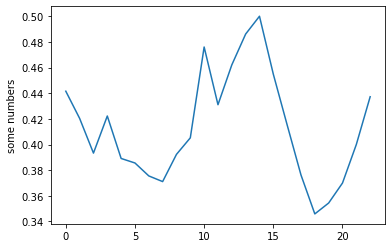

In [126]:
import matplotlib.pyplot as plt
plt.plot(np.squeeze(X_test[1:2:,1:2,:]))
plt.ylabel('some numbers')
plt.show()

### Przewidziane temperatury

(1, 26, 23)


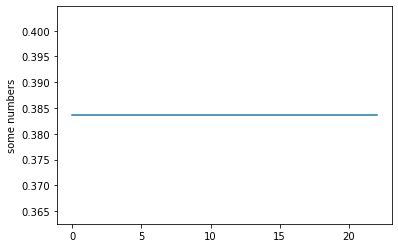

In [127]:
temps = []
temp_row = np.array(X_test[0:1,:,:]) 
for i in range(24):
    predicted = model.predict(temp_row)
    
    predicted[0,7] = int(i>=22 or i<=5)
    predicted[0,8] = int(i>=6 and i<=13)
    predicted[0,9] = int(i>=14 and i<=21)
    
    predicted[0,10] = temp_row[0, 10, 0]
    predicted[0,11] = temp_row[0, 11, 0]
    predicted[0,12] = temp_row[0, 12, 0]
    predicted[0,13] = temp_row[0, 13, 0]
    predicted[0,14] = temp_row[0, 14, 0]
    predicted[0,15] = temp_row[0, 15, 0]
    
    predicted = np.expand_dims(predicted, axis=2)
    temp_row = np.append(arr=temp_row, values=predicted, axis=2)
    temp_row = temp_row[:,:,1:]
print(temp_row.shape)


plt.plot(np.squeeze(temp_row[:,1:2,:]))
plt.ylabel('some numbers')
plt.show()

## 